In [55]:
import numpy as np
import scipy.ndimage
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## set directory of telescope aperture and list contents

In [35]:
telap_dir = os.path.abspath('../Apertures/JPL/2016-01-15')
print telap_dir
print("Contents:")
os.listdir(telap_dir)

/Users/neil/STScI/SCDA/Apertures/JPL/2016-01-15
Contents:


['._00README.TXT',
 '._cross_spiders_1000pix_10.0cm.fits',
 '._cross_spiders_1000pix_2.5cm.fits',
 '._cross_spiders_2000pix_10.0cm.fits',
 '._cross_spiders_2000pix_2.5cm.fits',
 '._hex1_1000pix.fits',
 '._hex1_2000pix.fits',
 '._hex2_1000pix.fits',
 '._hex2_2000pix.fits',
 '._hex3_1000pix.fits',
 '._hex3_2000pix.fits',
 '._hex4_1000pix.fits',
 '._hex4_2000pix.fits',
 '._keystone24_1000pix.fits',
 '._keystone24_2000pix.fits',
 '._offset_y_spiders_60deg_1000pix_10.0cm.fits',
 '._offset_y_spiders_60deg_1000pix_2.5cm.fits',
 '._offset_y_spiders_60deg_2000pix_10.0cm.fits',
 '._offset_y_spiders_60deg_2000pix_2.5cm.fits',
 '._piewedge12_1000pix.fits',
 '._piewedge12_2000pix.fits',
 '._piewedge8_1000pix.fits',
 '._piewedge8_2000pix.fits',
 '._segmented_aperture_files.pdf',
 '._t_spiders_1000pix_10.0cm.fits',
 '._t_spiders_1000pix_2.5cm.fits',
 '._t_spiders_2000pix_10.0cm.fits',
 '._t_spiders_2000pix_2.5cm.fits',
 '._x_spiders_1000pix_10.0cm.fits',
 '._x_spiders_1000pix_2.5cm.fits',
 '._x_spide

## Load an aperture and plot it

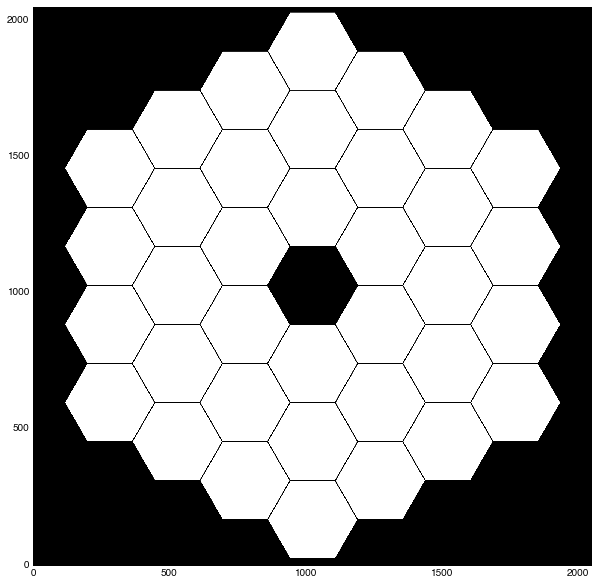

In [56]:
telap_fname = os.path.join(telap_dir, "hex3_2000pix.fits")
telap_hdulist = fits.open(telap_fname, "readonly")
telap_orig = telap_hdulist[0].data
plt.figure(figsize=(10,10))
plt.imshow(telap_orig)

## Shift to re-center

In [92]:
# I assume the aperture center is at (L/2, L/2), in zero-base indices.
# We want to shift the center it to (L/2-0.5, L/2-0.5)
L = telap_orig.shape[0]
telap_rc = scipy.ndimage.shift(telap_orig, (-0.5, -0.5), order=1)

### Prove it's symmetric

In [93]:
telap_left = telap_rc[:,:L/2] # left half
telap_right = telap_rc[:,L/2:] # right half
telap_top = telap_rc[L/2:,:] # left half
telap_bot = telap_rc[:L/2,:] # right half
leftright_diff = telap_left - telap_right[:,::-1]
topbot_diff = telap_top - telap_bot[::-1,:]
max_abs_leftright_diff = np.max(np.abs(leftright_diff))
max_abs_topbot_diff = np.max(np.abs(topbot_diff))
print('Max absolute left-right difference = {:g}'.format(max_abs_leftright_diff))
print('Max absolute top-bottom difference = {:g}'.format(max_abs_topbot_diff))

Max absolute left-right difference = 0.0454545
Max absolute top-bottom difference = 0.0454545


<matplotlib.colorbar.Colorbar instance at 0x151700b00>

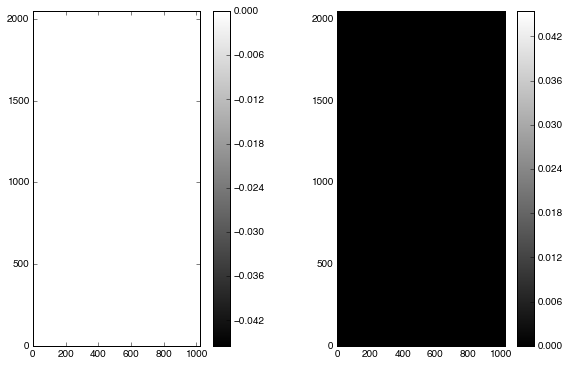

In [82]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(leftright_diff)
plt.colorbar()
plt.subplot(122)
plt.imshow(topbot_diff.T)
plt.colorbar()

## Bin to abritrary integer size, crop to quadrant

In [163]:
N_orig = 1000 # not 1024
N_fin = 300
scalefac = float(N_fin)/N_orig
telap_rcb = scipy.ndimage.zoom(telap_rc, scalefac, order=1)
L_bin = telap_rcb.shape[0]

In [165]:
telap_rc.shape

(2048, 2048)

In [166]:
telap_rcb.shape

(614, 614)

In [167]:
telap_rcbq = telap_rcb[L_bin/2:L_bin/2+N_fin, L_bin/2:L_bin/2+N_fin]
#telap_rcb_quad = telap_rcb[L_bin/2:L_bin/2+N_bin+1, L_bin/2:L_bin/2+N_bin]
#telap_rcb_quad = telap_rcb[L_bin/2:, L_bin/2:L_bin/2+N_bin]
telap_rcbq.shape
# Check max value of outer row and outer column
print np.max(telap_rcbq[-1,:])
print np.max(telap_rcbq[:,-1])

0.336362288164
0.0


(-0.5, 299.5, -0.5, 299.5)

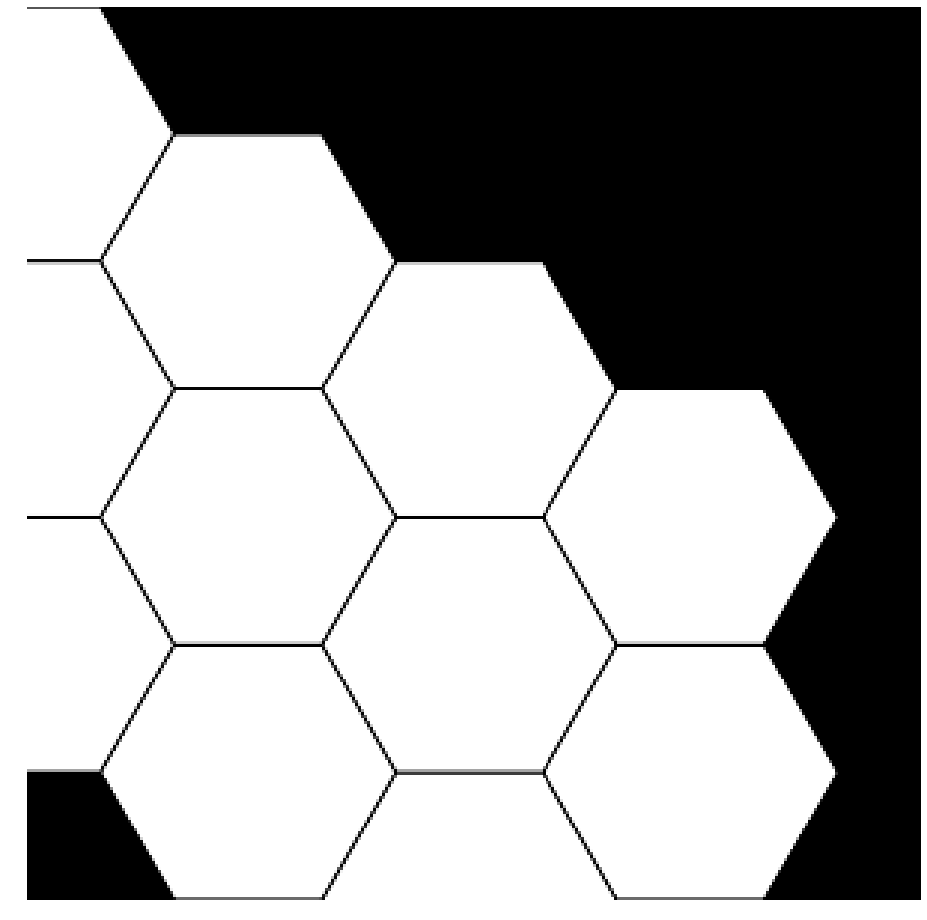

In [171]:
plt.figure(figsize=(16,16))
plt.imshow(telap_rcbq)
plt.axis('off')

### Form new FITS filename and write

In [194]:
binned_telap_dir = "../Apertures/STScI"
if not os.path.exists(binned_telap_dir):
    os.mkdir(binned_telap_dir)
print binned_telap_dir

../Apertures/STScI


In [192]:
telap_fname_tail = os.path.basename(telap_fname)
print telap_fname_tail
telap_label = telap_fname_tail.split("_")[0]
print telap_label
telap_label
telap_rcbq_fname = os.path.join(binned_telap_dir, "{:s}_quart_N{:04d}.fits".format(telap_label, N_bin))
print telap_rcbq_fname

hex3_2000pix.fits
hex3
../Apertures/STScI/hex3_quart_N0300.fits


In [193]:
telap_rcbq_hdu = fits.PrimaryHDU(telap_rcbq)
telap_rcbq_hdu.writeto(telap_rcbq_fname, clobber=True)